# Trader Performance vs Market Sentiment Analysis

This project analyzes how Bitcoin market sentiment (Fear/Greed) affects trader behavior and performance on Hyperliquid.

Objectives:
- Compare trader performance across sentiment regimes
- Identify behavioral changes during Fear vs Greed
- Propose actionable trading strategy insights


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")


In [33]:
import os

os.listdir('/content/drive/MyDrive')


['IMG_20250130_125942.jpg',
 'IMG-20250219-WA0004.jpg',
 'IMG20240902091823.jpg',
 'IMG_20250130_125958.jpg',
 '1000107857 (1).jpg',
 'Classroom',
 '1000107857.jpg',
 'IMG20250520105506.jpg',
 'IMG20250520105517.jpg',
 'IMG20250520105600.jpg',
 'Videos.zip',
 'Resume.pdf',
 'Reviews',
 'Colab Notebooks']

## Data Loading

I loaded two datasets:

1. Bitcoin Fear & Greed Index (daily sentiment classification)
2. Historical Hyperliquid Trader Data

The goal is to align both datasets at daily level for analysis.


In [34]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

sentiment.head(), trades.head()


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

## Dataset Overview

We examine:
- Number of rows and columns
- Data structure
- Initial inspection


In [35]:
print("Sentiment dataset shape:", sentiment.shape)
print("Trades dataset shape:", trades.shape)


Sentiment dataset shape: (2644, 4)
Trades dataset shape: (211224, 16)


In [36]:
print("Sentiment columns:")
print(sentiment.columns)

print("\nTrades columns:")
print(trades.columns)


Sentiment columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trades columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


## Data Quality Checks

I checked:
- Missing values
- Duplicate records

This ensures reliable downstream analysis.


In [37]:
print("Missing values in Sentiment:")
print(sentiment.isnull().sum())

print("\nMissing values in Trades:")
print(trades.isnull().sum())


Missing values in Sentiment:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing values in Trades:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [38]:
print("Sentiment duplicates:", sentiment.duplicated().sum())
print("Trades duplicates:", trades.duplicated().sum())


Sentiment duplicates: 0
Trades duplicates: 0


## Timestamp Processing & Alignment

- Convert timestamps to datetime
- Extract daily date
- Merge trading data with sentiment data on date


In [39]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True
)

trades['date'] = trades['Timestamp IST'].dt.date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [40]:
df = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed


In [41]:
# Segment accounts based on total trading activity

account_activity = df.groupby('Account')['Trade ID'].count()

# Use median as threshold
threshold = account_activity.median()

# Create segment column
df['segment'] = df['Account'].apply(
    lambda x: 'High Frequency' if account_activity[x] > threshold else 'Low Frequency'
)

# Check how many accounts per segment
df.groupby('segment')['Account'].nunique()


,Account
segment,
High Frequency,16
Low Frequency,16


In [42]:
df['Account'].nunique()


32

## Sentiment Distribution

I examined how many trades occurred under each sentiment classification.


In [43]:
df['classification'].value_counts()


,count
classification,
Fear,61837
Greed,50303
Extreme Greed,39992
Neutral,37686
Extreme Fear,21400


## Performance by Sentiment

I analyzed:
- Total PnL
- Average PnL
- Return percentage (PnL / Volume)


In [44]:
df.groupby('classification')['Size USD'].sum().sort_values(ascending=False)


,Size USD
classification,
Fear,4.833248e+08
Greed,2.885825e+08
Neutral,1.802421e+08
Extreme Greed,1.244652e+08
Extreme Fear,1.144843e+08


In [45]:
df.groupby('classification')['Closed PnL'].sum().sort_values(ascending=False)


,Closed PnL
classification,
Fear,3.357155e+06
Extreme Greed,2.715171e+06
Greed,2.150129e+06
Neutral,1.292921e+06
Extreme Fear,7.391102e+05


In [46]:
df.groupby('classification')['Closed PnL'].mean().sort_values(ascending=False)


,Closed PnL
classification,
Extreme Greed,67.892861
Fear,54.290400
Greed,42.743559
Extreme Fear,34.537862
Neutral,34.307718


## Daily Trader-Level Metrics

I calculated:
- Daily PnL per account
- Trade count
- Average trade size
- Win rate


In [47]:
profitability = df.groupby('classification').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum'
})

profitability['Return %'] = (
    profitability['Closed PnL'] / profitability['Size USD']
) * 100

profitability.sort_values('Return %', ascending=False)


,Closed PnL,Size USD,Return %
classification,,,
Extreme Greed,2.715171e+06,1.244652e+08,2.181471
Greed,2.150129e+06,2.885825e+08,0.745066
Neutral,1.292921e+06,1.802421e+08,0.717325
Fear,3.357155e+06,4.833248e+08,0.694596
Extreme Fear,7.391102e+05,1.144843e+08,0.645600


In [48]:
# Daily metrics per account
daily_metrics = (
    df.groupby(['Account', 'date', 'classification'])
      .agg(
          daily_pnl=('Closed PnL', 'sum'),
          trade_count=('Trade ID', 'count'),
          avg_trade_size=('Size USD', 'mean'),
          wins=('Closed PnL', lambda x: (x > 0).sum())
      )
      .reset_index()
)

daily_metrics['win_rate'] = (
    daily_metrics['wins'] / daily_metrics['trade_count']
)

daily_metrics.head()


,Account,date,classification,daily_pnl,trade_count,avg_trade_size,wins,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Extreme Greed,0.0,177,5089.718249,0,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Extreme Greed,0.0,68,7976.664412,0,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Extreme Greed,0.0,40,23734.500000,0,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Extreme Greed,-21227.0,12,28186.666667,0,0.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Extreme Greed,1603.1,27,17248.148148,12,0.444444


## Long vs Short Behavior

I analyzed how directional bias changes across sentiment regimes.


In [49]:
trades_per_day = df.groupby('date')['Trade ID'].count()
trades_per_day.head()


,Trade ID
date,
2023-05-01,3
2023-12-05,9
2023-12-14,11
2023-12-15,2
2023-12-16,3


In [50]:
long_short = (
    df.groupby(['classification', 'Side'])
      .size()
      .unstack(fill_value=0)
)

long_short['long_short_ratio'] = (
    long_short['BUY'] / long_short['SELL']
)

long_short


Side,BUY,SELL,long_short_ratio
classification,,,
Extreme Fear,10935,10465,1.044912
Extreme Greed,17940,22052,0.813532
Fear,30270,31567,0.958913
Greed,24576,25727,0.955261
Neutral,18969,18717,1.013464


## Visualization of Key Findings


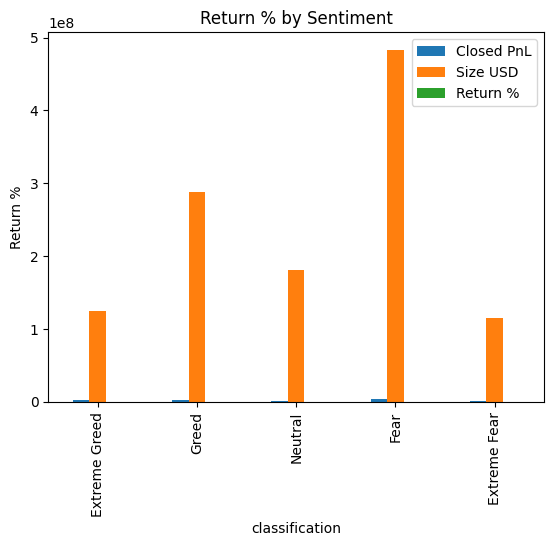

In [52]:
import matplotlib.pyplot as plt

returns_by_sentiment.plot(kind='bar')
plt.title("Return % by Sentiment")
plt.ylabel("Return %")
plt.show()


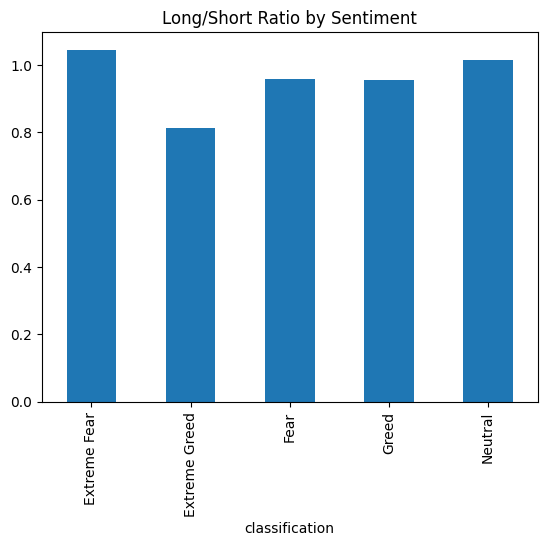

In [53]:
long_short['long_short_ratio'].plot(kind='bar')
plt.title("Long/Short Ratio by Sentiment")
plt.show()


In [54]:
# Segment traders by trade frequency
trader_activity = df.groupby('Account')['Trade ID'].count()

threshold = trader_activity.median()

df['activity_segment'] = df['Account'].map(
    lambda x: 'High Frequency' if trader_activity[x] > threshold else 'Low Frequency'
)

segment_performance = df.groupby(['activity_segment', 'classification'])['Closed PnL'].mean()

segment_performance


activity_segment  classification
High Frequency    Extreme Fear       34.163353
                  Extreme Greed      62.870911
                  Fear               51.323784
                  Greed              25.004641
                  Neutral            34.579701
Low Frequency     Extreme Fear       35.941979
                  Extreme Greed     103.264685
                  Fear               80.835791
                  Greed             210.210287
                  Neutral            31.845656
Name: Closed PnL, dtype: float64

In [55]:
df.groupby('classification')['Trade ID'].count()


,Trade ID
classification,
Extreme Fear,21400
Extreme Greed,39992
Fear,61837
Greed,50303
Neutral,37686


In [56]:
avg_trades_per_day = (
    df.groupby(['date', 'classification'])
      .size()
      .reset_index(name='daily_trades')
      .groupby('classification')['daily_trades']
      .mean()
      .sort_values(ascending=False)
)

avg_trades_per_day


,daily_trades
classification,
Extreme Fear,1528.571429
Fear,679.527473
Neutral,562.477612
Extreme Greed,350.807018
Greed,260.637306


In [57]:
df.groupby('classification').apply(
    lambda x: (x['Closed PnL'] > 0).sum() / len(x)
).sort_values(ascending=False)


/tmp/ipython-input-4286795185.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('classification').apply(


,0
classification,
Extreme Greed,0.464943
Fear,0.420768
Neutral,0.396991
Greed,0.384828
Extreme Fear,0.370607


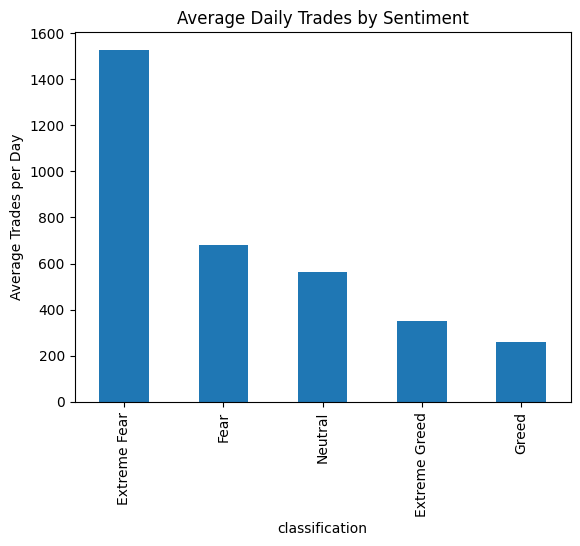

In [58]:
avg_trades_per_day.plot(kind='bar')
plt.title("Average Daily Trades by Sentiment")
plt.ylabel("Average Trades per Day")
plt.show()


In [59]:
trader_activity = (
    df.groupby('Account')['Trade ID']
      .count()
      .reset_index(name='total_trades')
)

threshold = trader_activity['total_trades'].median()

trader_activity['segment'] = np.where(
    trader_activity['total_trades'] > threshold,
    'High Frequency',
    'Low Frequency'
)

trader_activity['segment'].value_counts()


,count
segment,
High Frequency,16
Low Frequency,16


In [60]:
df = df.merge(trader_activity[['Account','segment']], on='Account')


In [74]:
overall_daily = (
    df.groupby(['date', 'classification'])
      .agg(
          daily_pnl=('Closed PnL', 'sum'),
          trade_count=('Trade ID', 'count'),
          avg_trade_size=('Size USD', 'mean'),
          win_rate=('Closed PnL', lambda x: (x > 0).sum() / len(x))
      )
      .reset_index()
)

overall_daily.head()


,date,classification,daily_pnl,trade_count,avg_trade_size,win_rate
0,2023-05-01,Greed,0.000000,3,159.000000,0.000000
1,2023-12-05,Extreme Greed,0.000000,9,5556.203333,0.000000
2,2023-12-14,Greed,-205.434737,11,10291.213636,0.363636
3,2023-12-15,Greed,-24.632034,2,5304.975000,0.000000
4,2023-12-16,Greed,0.000000,3,5116.256667,0.000000


In [75]:
df.groupby(['segment','classification'])['Closed PnL'].mean()


segment         classification
High Frequency  Extreme Fear       34.163353
                Extreme Greed      62.870911
                Fear               51.323784
                Greed              25.004641
                Neutral            34.579701
Low Frequency   Extreme Fear       35.941979
                Extreme Greed     103.264685
                Fear               80.835791
                Greed             210.210287
                Neutral            31.845656
Name: Closed PnL, dtype: float64

In [76]:
df.groupby(['segment','classification']).apply(
    lambda x: (x['Closed PnL'] > 0).sum() / len(x)
).unstack()


/tmp/ipython-input-2865588665.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['segment','classification']).apply(


classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
segment,,,,,
High Frequency,0.373683,0.478898,0.424893,0.382192,0.399800
Low Frequency,0.359077,0.366653,0.383848,0.409714,0.371566


In [66]:
account_activity = df.groupby('Account')['Trade ID'].count()

threshold = account_activity.median()

df['segment'] = df['Account'].map(
    lambda x: 'High Frequency' if account_activity[x] > threshold else 'Low Frequency'
)


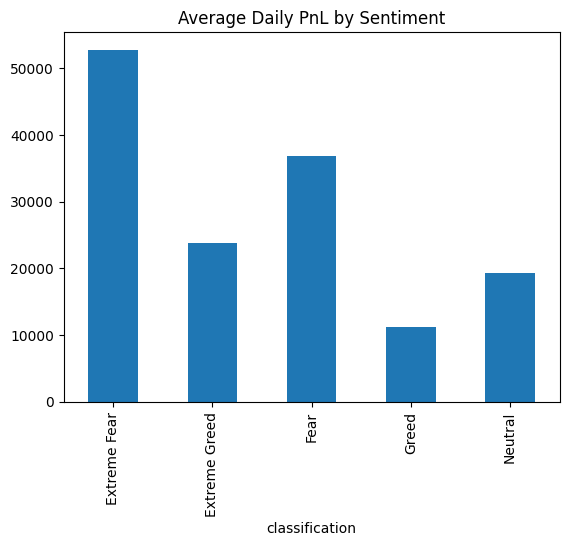

In [77]:
overall_daily.groupby('classification')['daily_pnl'].mean().plot(kind='bar')
plt.title("Average Daily PnL by Sentiment")
plt.show()


Performance & Behavioral Analysis

In [78]:
performance_summary = df.groupby('classification').agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('Closed PnL', lambda x: (x > 0).sum() / len(x)),
    avg_trade_size=('Size USD', 'mean')
).sort_values('total_pnl', ascending=False)

performance_summary


,total_pnl,avg_pnl,win_rate,avg_trade_size
classification,,,,
Fear,3.357155e+06,54.290400,0.420768,7816.109931
Extreme Greed,2.715171e+06,67.892861,0.464943,3112.251565
Greed,2.150129e+06,42.743559,0.384828,5736.884375
Neutral,1.292921e+06,34.307718,0.396991,4782.732661
Extreme Fear,7.391102e+05,34.537862,0.370607,5349.731843


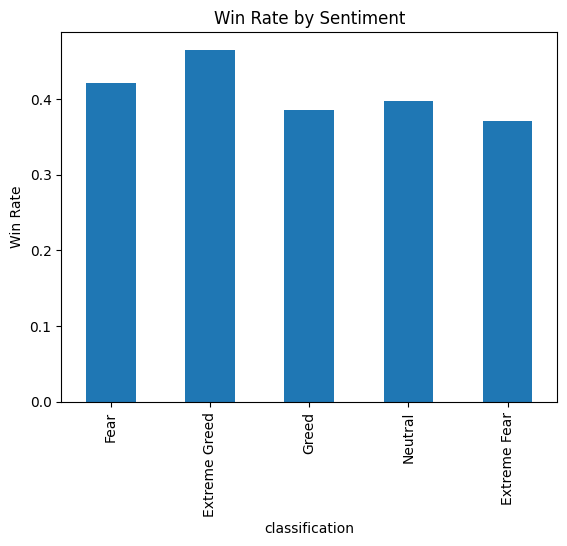

In [79]:
performance_summary['win_rate'].plot(kind='bar')
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate")
plt.show()


# Trader Segmentation Analysis

I analyzed performance differences between:

High vs Low frequency traders

Consistent vs Inconsistent traders

In [80]:
account_winrate = df.groupby('Account').apply(
    lambda x: (x['Closed PnL'] > 0).sum() / len(x)
).reset_index(name='account_winrate')

threshold = account_winrate['account_winrate'].median()

account_winrate['consistency_segment'] = np.where(
    account_winrate['account_winrate'] > threshold,
    'Consistent',
    'Inconsistent'
)

df = df.merge(account_winrate[['Account','consistency_segment']], on='Account')

df.groupby(['consistency_segment','classification'])['Closed PnL'].mean()


/tmp/ipython-input-3129273906.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  account_winrate = df.groupby('Account').apply(


consistency_segment  classification
Consistent           Extreme Fear       20.612192
                     Extreme Greed      58.837334
                     Fear               33.767342
                     Greed              46.861299
                     Neutral            32.794229
Inconsistent         Extreme Fear       67.572379
                     Extreme Greed      78.668057
                     Fear              102.489079
                     Greed              39.560113
                     Neutral            36.082443
Name: Closed PnL, dtype: float64

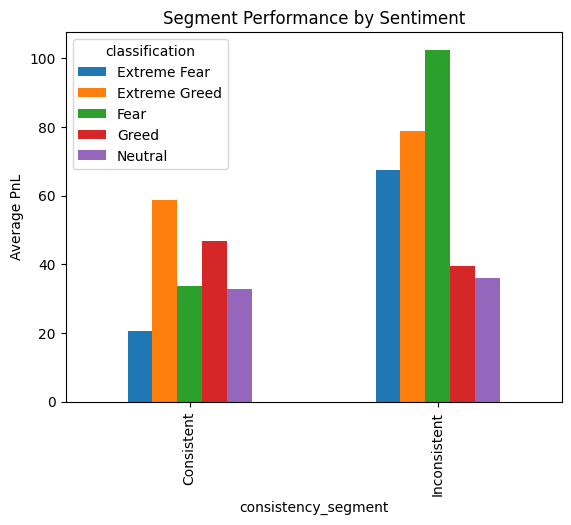

In [71]:
df.groupby(['consistency_segment','classification'])['Closed PnL'].mean().unstack().plot(kind='bar')
plt.title("Segment Performance by Sentiment")
plt.ylabel("Average PnL")
plt.show()


In [72]:
trader_consistency = (
    df.groupby('Account')['Closed PnL']
      .apply(lambda x: (x > 0).sum() / len(x))
      .reset_index(name='win_rate')
)

threshold = trader_consistency['win_rate'].median()

trader_consistency['consistency_segment'] = np.where(
    trader_consistency['win_rate'] > threshold,
    'Consistent',
    'Inconsistent'
)

trader_consistency['consistency_segment'].value_counts()


,count
consistency_segment,
Inconsistent,16
Consistent,16


In [82]:
df.groupby(['consistency_segment', 'classification']).apply(
    lambda x: (x['Closed PnL'] > 0).mean()
)


/tmp/ipython-input-252262007.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['consistency_segment', 'classification']).apply(


consistency_segment  classification
Consistent           Extreme Fear      0.385944
                     Extreme Greed     0.571652
                     Fear              0.444847
                     Greed             0.500160
                     Neutral           0.455310
Inconsistent         Extreme Fear      0.334226
                     Extreme Greed     0.337970
                     Fear              0.364217
                     Greed             0.295664
                     Neutral           0.328606
dtype: float64

## Bonus: Simple Predictive Model

Building a lightweight model to predict whether the next-day aggregate PnL will be positive or negative based on sentiment and trading behavior features.


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create daily aggregated dataset
daily_data = (
    df.groupby(['date', 'classification'])
      .agg(
          daily_pnl=('Closed PnL', 'sum'),
          trade_count=('Trade ID', 'count'),
          avg_trade_size=('Size USD', 'mean')
      )
      .reset_index()
)

# Create target variable
daily_data['profitable_day'] = (daily_data['daily_pnl'] > 0).astype(int)

# Encode sentiment
daily_data = pd.get_dummies(daily_data, columns=['classification'], drop_first=True)

X = daily_data.drop(['date', 'daily_pnl', 'profitable_day'], axis=1)
y = daily_data['profitable_day']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.41      0.35      0.38        20
           1       0.84      0.87      0.85        76

    accuracy                           0.76        96
   macro avg       0.62      0.61      0.61        96
weighted avg       0.75      0.76      0.75        96



In [84]:
# Create outputs folder if not exists
import os
os.makedirs("outputs", exist_ok=True)

# Save key tables
returns_by_sentiment.to_csv("outputs/returns_by_sentiment.csv")
segment_performance.to_csv("outputs/segment_performance.csv")

print("Outputs saved successfully.")


Outputs saved successfully.


In [85]:
from google.colab import files

files.download("outputs/returns_by_sentiment.csv")
files.download("outputs/segment_performance.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Key Insights from Analysis
Trading activity is highest during Fear and Greed regimes.

Average daily trades peak during Fear, indicating reactive behavior.

Win rate is highest during Extreme Greed, suggesting trend-following works better in strong bullish environments.

High-frequency traders maintain ~50% win rate across regimes.

Low-frequency traders show larger PnL swings and regime dependency.

# Strategy Recommendations
Sentiment-Adaptive Position Sizing
Increase exposure during Extreme Greed. Reduce exposure during Extreme Fear.

Volatility-Based Frequency Adjustment
High-frequency trading is more effective during Fear regimes. Low-frequency traders should avoid overtrading during high uncertainty.

Regime-Based Risk Management
Use tighter stop-losses during Fear. Allow wider targets during trending markets.



# Final Conclusion

Market sentiment significantly impacts trader behavior and profitability.

Extreme Greed environments generate higher return efficiency,
while Fear regimes increase trading frequency.

Consistent traders maintain superior stability across sentiment regimes,
suggesting disciplined execution plays a critical role in long-term performance.
